In [ ]:
from backend import workflow
from imagen_pytorch import Unet, Imagen, ImagenTrainer
import torch
from IPython.display import clear_output
import gc
import time

In [2]:
source_directory = 'datasets/dimensi0n/imagenet-256/zebra'
using_checkpoint = 'checkpoints/a_model.pt'

dataloader = workflow(source_directory)

Loading T5 Tokenizer and Encoder Model (t5-large)...
T5 models loaded.


In [3]:
# Imagen & Unets

unet1 = Unet(
    dim = 32,
    cond_dim = 512,
    dim_mults = (1, 2, 4, 8),
    num_resnet_blocks = 3,
    layer_attns = (False, True, True, True)
)

unet2 = Unet(
    dim = 32,
    cond_dim = 512,
    dim_mults = (1, 2, 4, 8),
    num_resnet_blocks = (2, 4, 8, 8),
    layer_attns = (False, False, False, True),
    layer_cross_attns = (False, False, False, True)
)

# imagen, which contains the unets above (base unet and super resoluting ones)

imagen = Imagen(
    unets = (unet1, unet2),
    text_encoder_name = 't5-large',
    image_sizes = (64, 256),
    timesteps = 1000,
    cond_drop_prob = 0.1
).cuda()

The base dimension of your u-net should ideally be no smaller than 128, as recommended by a professional DDPM trainer https://nonint.com/2022/05/04/friends-dont-let-friends-train-small-diffusion-models/


In [12]:
#Preparing imagen and trainer

imagen.train()
trainer = ImagenTrainer(imagen).cuda()
trainer.train()
clear_output()

In [13]:
# Load the model

trainer.load(using_checkpoint)
clear_output()

In [ ]:
# Code for running the training

num_epochs = 10
unet_toTrain = 2    # Can't train both unets at the same time, need to save checkpoint and re-initiate the trainer when changing unets  z

#Training in epochs, each unet is trained once in each epoch
losses = 0
for epoch in range(num_epochs):
    clear_output()
    print(f"Epoch {epoch+1}/{num_epochs}, Training UNet {unet_toTrain}, Prev epoch avg loss: {losses/len(dataloader)}")
    losses = 0
    for images_batch, text_embeds_batch in dataloader:
        if images_batch.numel() == 0: continue # Skip if batch is empty after filtering

        images_batch = images_batch.cuda()
        text_embeds_batch = text_embeds_batch.cuda()

        loss = trainer(images_batch, text_embeds = text_embeds_batch, unet_number = unet_toTrain)
        losses += loss
        trainer.update(unet_number = unet_toTrain)
        print(f"Loss: {loss}")

In [7]:
# Save the model
trainer.save(using_checkpoint)

checkpoint saved to checkpoints/a_model.pt


In [ ]:
# Workflow code for less supervised training
num_epochs_perRound = 120
unet_toTrain = 1

rounds = 3
change_unet_afterRound = 1

trainer = ImagenTrainer(imagen).cuda()

rounds_scores = []

for round in range(rounds):
    if change_unet_afterRound == round:
        unet_toTrain = 2
    del trainer
    gc.collect()
    torch.cuda.empty_cache()
    imagen.train()
    trainer = ImagenTrainer(imagen).cuda()
    trainer.train()
    clear_output()
    
    trainer.load(using_checkpoint)
    clear_output()
    losses = 0
    round_losses = 0
    for epoch in range(num_epochs_perRound):
        clear_output()
        print(f"Round {round+1}, Epoch {epoch+1}/{num_epochs_perRound}, Training UNet {unet_toTrain}, Prev epoch avg loss: {losses/len(dataloader)}")
        losses = 0
        for images_batch, text_embeds_batch in dataloader:
            if images_batch.numel() == 0: continue

            images_batch = images_batch.cuda()
            text_embeds_batch = text_embeds_batch.cuda()

            loss = trainer(images_batch, text_embeds = text_embeds_batch, unet_number = unet_toTrain)
            losses += loss
            trainer.update(unet_number = unet_toTrain)
            print(f"Loss: {loss}")
        round_losses += losses/len(dataloader)
        if epoch == num_epochs_perRound - 1:
            print(f"Last epoch avg loss: {losses/len(dataloader)}")
    rounds_scores.append(round_losses/num_epochs_perRound)
    trainer.save(using_checkpoint)

clear_output()
for i, score in enumerate(rounds_scores):
    print(f"Round {i+1} avg loss: {score}")

images = trainer.sample(texts = [
    'two zebras in a field',
    'two zebras in a zoo',
    'the zebra is black and white'
], cond_scale = 3.)

import matplotlib.pyplot as plt
import torchvision.utils as vutils

images_cpu = images.cpu().detach()
images_cpu = torch.clamp(images_cpu, 0, 1)
grid = vutils.make_grid(images_cpu, nrow=len(images_cpu), padding=2, normalize=False)
np_grid = grid.permute(1, 2, 0).numpy()

plt.figure(figsize=(10, 5))
plt.imshow(np_grid)
plt.axis('off')
plt.show()

Round 3, Epoch 10/120, Training UNet 2, Prev epoch avg loss: 0.019651778590499977
Loss: 0.020621418952941895
Loss: 0.026351667940616608
Loss: 0.03610718250274658
Loss: 0.014582048170268536
Loss: 0.01630048081278801
Loss: 0.008391543291509151
Loss: 0.0364374965429306
Loss: 0.008678454905748367
Loss: 0.04799403250217438
Loss: 0.007791782729327679
Loss: 0.004079102072864771
Loss: 0.01366442907601595
Loss: 0.012837917543947697
Loss: 0.011599106714129448
Loss: 0.026630623266100883
Loss: 0.013097293674945831
Loss: 0.015281915664672852
Loss: 0.013788197189569473
Loss: 0.00949086807668209
Loss: 0.01338103972375393
Loss: 0.013070383109152317
Loss: 0.03715408593416214
Loss: 0.03154318034648895
Loss: 0.01133501622825861
Loss: 0.03030380792915821
Loss: 0.02507426217198372
Loss: 0.03787553310394287
Loss: 0.02571241185069084
Loss: 0.02857878804206848
Loss: 0.025921646505594254
Loss: 0.024854294955730438
Loss: 0.02603560872375965
Loss: 0.029813367873430252
Loss: 0.01357848010957241
Loss: 0.0241840034

sampling loop time step: 100%|██████████| 1000/1000 [01:37<00:00, 10.25it/s]
2it [03:02, 91.22s/it]


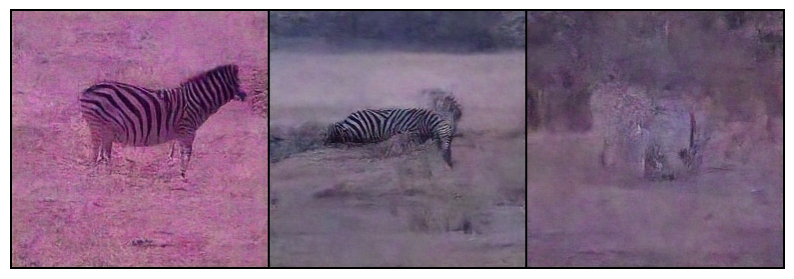

In [8]:
# Generate images

images = trainer.sample(texts = [
    'two zebras in a field',
    'two zebras in a zoo',
    'the zebra is black and white'
], cond_scale = 3.)

# Code for displaying the generated images

import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Move images tensor to CPU and detach from gradient computation
images_cpu = images.cpu().detach()

# If your images are normalized to [-1, 1], denormalize them to [0, 1]
# images_cpu = (images_cpu + 1) / 2 # Uncomment if you used transforms.Normalize(...)

# Clamp values to [0, 1] just in case
images_cpu = torch.clamp(images_cpu, 0, 1)

# Make a grid of images (rows = number of samples)
grid = vutils.make_grid(images_cpu, nrow=len(images_cpu), padding=2, normalize=False) # normalize=False as we clamped

# Convert grid tensor to numpy array and transpose dimensions for matplotlib
# (C, H, W) -> (H, W, C)
np_grid = grid.permute(1, 2, 0).numpy()

# Display the grid
plt.figure(figsize=(10, 5))
plt.imshow(np_grid)
plt.axis('off')
plt.show()